In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, SparseCategoricalCrossentropy
import pandas as pd
from PIL import Image


2024-02-19 21:51:40.148781: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 21:51:40.148816: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 21:51:40.148827: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 21:51:40.152369: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:1

# Download the following data set for the code to run:

- [Link](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg)
- After downloading, please make sure to include the annoations and eval files inside a directory named img_celeba
    - Make sure the images are inside a subdirectory named img_celeba



## Make sure it works on GPU

In [2]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-19 21:51:41.186235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 21:51:41.188771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 21:51:41.188793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Data exploration


In [3]:
# Define paths
base_dir = 'img_celeba'
bbox_excel_path = os.path.join(base_dir, 'list_bbox_celeba.txt')
identity_txt_path = os.path.join(base_dir, 'identity_CelebA.txt')
images_dir = os.path.join(base_dir, 'img_celeba')

# Read the Excel file for bounding boxes
bbox_df = pd.read_csv(bbox_excel_path, sep='\s+', skiprows=1)

# Read the identity file
identity_df = pd.read_csv(identity_txt_path, sep=" ", header=None, names=['image_id', 'identity'])
# Path to the evaluation partition file
eval_partition_path = os.path.join(base_dir, 'list_eval_partition.txt')

# Read the evaluation partition file
eval_partition_df = pd.read_csv(eval_partition_path, sep='\s+',
                                header=None, names=['image_id', 'evaluation_status'])

# Merge the evaluation partition data with the bounding boxes and identity data
merged_df = pd.merge(bbox_df, identity_df, on='image_id')
merged_df = pd.merge(merged_df, eval_partition_df, on='image_id')

# Split the merged data into training, validation, and testing datasets
train_df = merged_df[merged_df['evaluation_status'] == 0].drop(columns=['evaluation_status'])
val_df = merged_df[merged_df['evaluation_status'] == 1].drop(columns=['evaluation_status'])
test_df = merged_df[merged_df['evaluation_status'] == 2].drop(columns=['evaluation_status'])


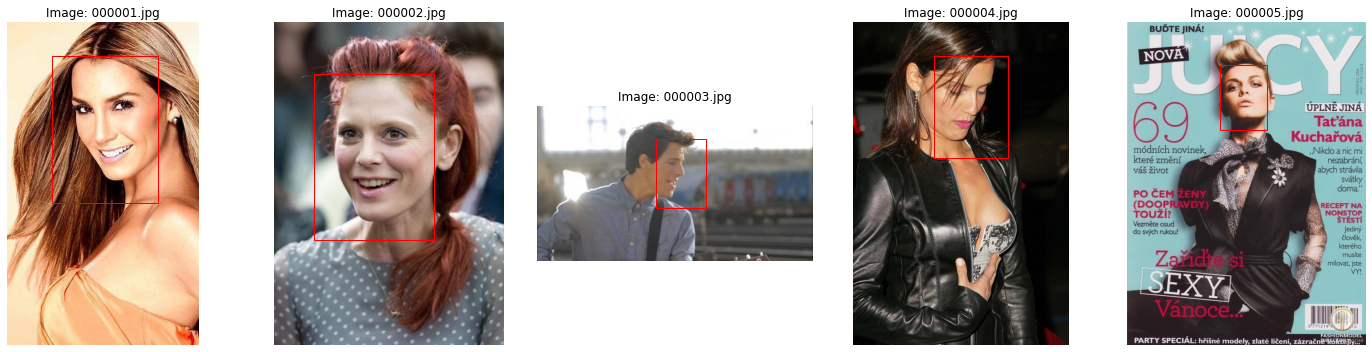

In [4]:
# Display first 5 images with bounding boxes and identity
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i, row in merged_df.iterrows():
    if i >= 5:  # Only process the first 5 entries
        break
    img_path = os.path.join(images_dir, row['image_id'])
    img = Image.open(img_path)

    x = row['x_1']
    y = row['y_1']

    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), row['width'], row['height'], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    axs[i].imshow(img)
    axs[i].add_patch(rect)
    axs[i].set_title(f"Image: {row['image_id']}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
class CelebADatasetTF:
    def __init__(self, dataframe, images_dir, target_size=(224, 224)):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.target_size = target_size

    def decode_image(self, filename, bbox, identity):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        return image, bbox, identity

    def resize_and_normalize(self, image, bbox, identity):
        # Calculate the scale factors for width and height
        original_size = tf.cast(tf.shape(image)[:2], tf.float32)  # [height, width]
        scale = self.target_size / original_size
        
        # Resize the image to the target size
        image = tf.image.resize(image, self.target_size)
        # Normalize the image to the [0, 1] range
        image = image / 255.0
        
        # Adjust bounding box coordinates
        # Assuming bbox format is [x_min, y_min, width, height]
        bbox = tf.cast(bbox, tf.float32)
        scaled_bbox = tf.stack([bbox[0] * scale[1], bbox[1] * scale[0], bbox[2] * scale[1], bbox[3] * scale[0]])
        
        return image, scaled_bbox, identity

    def load_and_preprocess(self, filepath, bbox, identity):
        image, bbox, identity = self.decode_image(filepath, bbox, identity)
        image, bbox, identity = self.resize_and_normalize(image, bbox, identity)
        return {'image': image, 'bbox': bbox, 'identity': identity}

    def make_dataset(self):
        paths = [os.path.join(self.images_dir, fname) for fname in self.dataframe.iloc[:, 0]]
        bboxes = self.dataframe.iloc[:, 1:5].values.astype('float32')
        identities = self.dataframe.iloc[:, 5].values.astype('int64')

        dataset = tf.data.Dataset.from_tensor_slices((paths, bboxes, identities))
        dataset = dataset.map(lambda x, y, z: self.load_and_preprocess(x, y, z), num_parallel_calls=tf.data.AUTOTUNE)
        return dataset

In [6]:
train_dataset_tf = CelebADatasetTF(dataframe=train_df, images_dir=images_dir).make_dataset()
val_dataset_tf = CelebADatasetTF(dataframe=val_df, images_dir=images_dir).make_dataset()
test_dataset_tf = CelebADatasetTF(dataframe=test_df, images_dir=images_dir).make_dataset()

2024-02-19 21:51:41.998873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 21:51:41.998913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 21:51:41.998923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 21:51:42.194373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-19 21:51:42.194401: I tensorflow/compile

In [7]:
for sample in train_dataset_tf.take(1):
    print("Image shape:", sample['image'].shape)
    print("Bounding box shape:", sample['bbox'].shape)
    print("Identity:", sample['identity'])

Image shape: (224, 224, 3)
Bounding box shape: (4,)
Identity: tf.Tensor(2880, shape=(), dtype=int64)


In [8]:
train_dataset_tf_batched = train_dataset_tf.batch(16).prefetch(tf.data.AUTOTUNE)

for batch in train_dataset_tf_batched.take(1):
    print("Batched images shape:", batch['image'].shape)  # Expect (32, 224, 224, 3) for a batch size of 32
    print("Batched bounding boxes shape:", batch['bbox'].shape)  # Expect (32, 4)
    print("Batched identities shape:", batch['identity'].shape)  # Expect (32,)


Batched images shape: (16, 224, 224, 3)
Batched bounding boxes shape: (16, 4)
Batched identities shape: (16,)


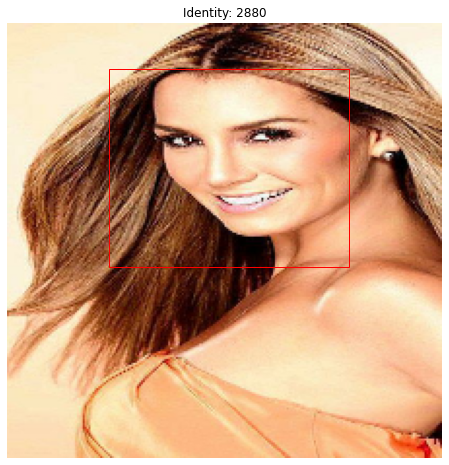

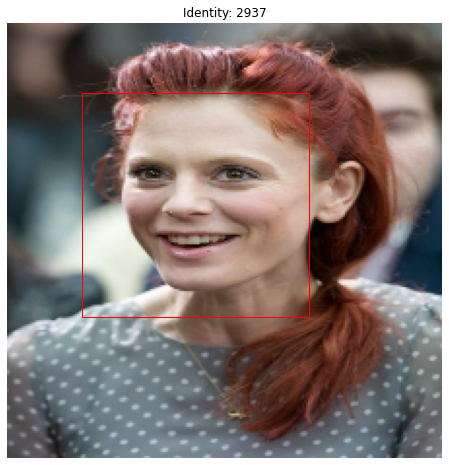

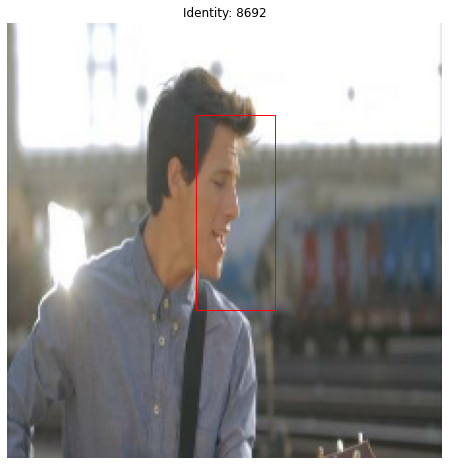

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_sample_with_bbox(sample):
    image, bbox, identity = sample['image'], sample['bbox'], sample['identity']
    plt.figure(figsize=(8, 8))
    plt.imshow(image.numpy())
    
    # Create a Rectangle patch
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    
    # Add the patch to the Axes
    plt.gca().add_patch(rect)
    plt.title(f"Identity: {identity.numpy()}")
    plt.axis('off')  # Hide axis
    plt.show()

# Display a few images from the training set with bounding boxes
for sample in train_dataset_tf.take(3):
    show_sample_with_bbox(sample)


In [10]:
batch_size = 16  # You can adjust this size as per your computational resources

# For the validation dataset
val_dataset_tf = val_dataset_tf.batch(batch_size).prefetch(tf.data.AUTOTUNE)
print("Finished Validation Loading")

# For the test dataset
test_dataset_tf = test_dataset_tf.batch(batch_size).prefetch(tf.data.AUTOTUNE)
print("Finished Test Loading")

# For the train dataset
train_dataset_tf = train_dataset_tf.batch(batch_size).prefetch(tf.data.AUTOTUNE)
print("Finished Train Loading")


Finished Validation Loading
Finished Test Loading
Finished Train Loading


In [11]:
len(train_dataset_tf)

10174

In [12]:
class MultiTaskCNN(Model):
    def __init__(self, num_classes):
        super(MultiTaskCNN, self).__init__()
        # Load a pre-trained ResNet50 model as a feature extractor
        # Note: TensorFlow doesn't have ResNet18 by default, using ResNet50 as an example
        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        self.features = base_model

        # Freeze the base_model
        self.features.trainable = False

        # Bounding box prediction head
        self.bbox_head = tf.keras.Sequential([
            GlobalAveragePooling2D(),
            Dense(4)  # 4 outputs for bbox (x, y, width, height)
        ])

        # Classifier head
        self.classifier_head = tf.keras.Sequential([
            GlobalAveragePooling2D(),
            Dense(num_classes)  # Outputs for classification
        ])

    def call(self, inputs):
        print("hello world")
        x = self.features(inputs)
        print("hello world 2 ")

        bbox = self.bbox_head(x)
        print("hello world 3")

        class_logits = self.classifier_head(x)
        print("hello world 4")

        return bbox, class_logits

In [13]:
# Assuming MultiTaskCNN class definition from the previous conversion

# Determine the number of unique classes in your training data
num_classes = len(train_df['identity'].unique())

# Initialize the model
model = MultiTaskCNN(num_classes=num_classes)

# Loss functions
bbox_loss_fn = MeanSquaredError()
class_loss_fn = SparseCategoricalCrossentropy(from_logits=True)

# Optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss={'bbox_head': bbox_loss_fn, 'classifier_head': class_loss_fn},
              metrics={'classifier_head': 'accuracy'})

In [ ]:
# Prepare the model for training.
model = MultiTaskCNN(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Metrics to track the average loss and current epoch loss
train_bbox_loss_metric = tf.keras.metrics.Mean()
train_class_loss_metric = tf.keras.metrics.Mean()
val_bbox_loss_metric = tf.keras.metrics.Mean()
val_class_loss_metric = tf.keras.metrics.Mean()

num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Reset metrics
    train_bbox_loss_metric.reset_states()
    train_class_loss_metric.reset_states()
    val_bbox_loss_metric.reset_states()
    val_class_loss_metric.reset_states()

    # Training loop
    counter = 0
    for batch in train_dataset_tf:
        print(f"Doing batch {counter + 1}")
        counter += 1
        images = batch['image']  # Correctly extract images tensor
        bboxes = batch['bbox']  # Correctly extract bounding boxes tensor
        labels = batch['identity']  # Correctly extract labels tensor
        with tf.GradientTape() as tape:
            pred_bboxes, pred_labels = model(images, training=True)  # Use extracted tensors
            bbox_loss = bbox_loss_fn(bboxes, pred_bboxes)
            class_loss = class_loss_fn(labels, pred_labels)
            total_loss = bbox_loss + class_loss

        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_bbox_loss_metric.update_state(bbox_loss)
        train_class_loss_metric.update_state(class_loss)

    # Validation loop
    for batch in val_dataset_tf:
        images = batch['image']  # Correctly extract images tensor
        bboxes = batch['bbox']  # Correctly extract bounding boxes tensor
        labels = batch['identity']  # Correctly extract labels tensor
        pred_bboxes, pred_labels = model(images, training=False)  # Use extracted tensors
        bbox_loss = bbox_loss_fn(bboxes, pred_bboxes)
        class_loss = class_loss_fn(labels, pred_labels)

        val_bbox_loss_metric.update_state(bbox_loss)
        val_class_loss_metric.update_state(class_loss)

    # Log results
    print(f"Epoch {epoch + 1}, "
          f"Train BBox Loss: {train_bbox_loss_metric.result().numpy():.4f}, "
          f"Train Class Loss: {train_class_loss_metric.result().numpy():.4f}, "
          f"Val BBox Loss: {val_bbox_loss_metric.result().numpy():.4f}, "
          f"Val Class Loss: {val_class_loss_metric.result().numpy():.4f}")